# Analysis of the 15-minute and 30-minute subsets of the cell cycle pulse-labeling dataset from scEU-seq

To demonstrate the precision and robustness of the Mosto method in estimating
the one-shot dataset, we benchmarked the estimated kinetic parameters of 15-minute and 30-minute subsets of the cell cycle pulse-labeling dataset.

In [1]:
import warnings

warnings.filterwarnings('ignore')
import dynamo as dyn

## Load and preprocess the data

In [2]:
filename = './data/rpe1.h5ad'
rpe1 = dyn.read(filename)

In [3]:
dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1.obs.exp_type.value_counts()
rpe1[rpe1.obs.exp_type == 'Chase', :].obs.time.value_counts()
rpe1[rpe1.obs.exp_type == 'Pulse', :].obs.time.value_counts()

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

In [4]:
rpe1_kinetics.layers['new'], rpe1_kinetics.layers['total'] = rpe1_kinetics.layers['ul'] + rpe1_kinetics.layers['sl'], \
                                                             rpe1_kinetics.layers['su'] + rpe1_kinetics.layers['sl'] + \
                                                             rpe1_kinetics.layers['uu'] + rpe1_kinetics.layers['ul']

del rpe1_kinetics.layers['uu'], rpe1_kinetics.layers['ul'], rpe1_kinetics.layers['su'], rpe1_kinetics.layers['sl']

In [5]:
rpe1_kinetics.obsm['X_RFP_GFP'] = rpe1_kinetics.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

In [6]:
# We use highly variable genes and the genes used in method A
cell_dancer_gene = ['KIF20A', 'AURKA', 'MIR100HG', 'PRC1', 'TNIK', 'CCNB1', 'ASF1B', 'KPNA2',
                    'C2orf69', 'NLGN1', 'EPB41', 'KNL1', 'FAM83D', 'MAGI1', 'NUSAP1', 
                    'MTMR6', 'CENPF', 'FKBP5', 'CKS2', 'CKAP2', 'MCTP1', 'RAD21', 'TPX2',
                    'CENPE', 'CCNA2', 'CEP55', 'KIF23', 'RASA1', 'BUB1', 'BRCA1', 'KIF20B',
                    'EFNB2', 'G2E3', 'DLEU2', 'FBXL20', 'HMMR', 'CDCA8', 'NEK2', 'CKAP5', 
                    'NUF2', 'AFF3', 'CIT', 'CDCA2', 'RACGAP1', 'KIF4A', 'RAD51B', 'IMMP2L', 
                    'NCAPG', 'DLGAP5', 'ANLN', 'ASPM', 'MCM10', 'IRS1', 'NCEH1', 'KIF2C', 
                    'NAV2', 'KIF14', 'KIF18A', 'TENM3', 'NGF', 'KIF11', 'PTPRJ', 'SMC4', 
                    'FST', 'PTX3', 'CENPP']

In [7]:
dyn.pp.recipe_monocle(
    rpe1_kinetics,
    tkey="time",
    experiment_type="one-shot",
    n_top_genes=1000,
    total_layers=False,
    keep_raw_layers=True,
    genes_to_append=cell_dancer_gene,
)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache 

Cells with a labeling duration of 15 and 30 minutes were taken as sub-data sets:

In [8]:
rpe1_15min = rpe1_kinetics[rpe1_kinetics.obs.time == 15, :]
rpe1_30min = rpe1_kinetics[rpe1_kinetics.obs.time == 30, :]

In [9]:
rpe1_15min.obs.time = rpe1_15min.obs.time.astype('float')
rpe1_15min.obs.time = rpe1_15min.obs.time / 60  # convert minutes to hours

rpe1_30min.obs.time = rpe1_30min.obs.time.astype('float')
rpe1_30min.obs.time = rpe1_30min.obs.time / 60  # convert minutes to hours

In [10]:
rpe1_15min_CSPss = rpe1_15min.copy()
rpe1_15min_Dynamo = rpe1_15min.copy()
del rpe1_15min

rpe1_30min_CSPss = rpe1_30min.copy()
rpe1_30min_Dynamo = rpe1_30min.copy()
del rpe1_30min

## Parameter inference and calculation of total RNA velocity

In [11]:
# for CSP with steady state

# 15 mins
rpe1_15min_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(rpe1_15min_CSPss,
                model="deterministic",
                est_method='CSP4ML_CSPss'
                )
dyn.tl.reduceDimension(rpe1_15min_CSPss, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_15min_CSPss, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

# 30 mins
rpe1_30min_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(rpe1_30min_CSPss,
                model="deterministic",
                est_method='CSP4ML_CSPss'
                )
dyn.tl.reduceDimension(rpe1_30min_CSPss, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_30min_CSPss, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [7.3979s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:00, 2402.91it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 1000it [00:00, 3114.15it/s]


(1000, 1)
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [4.8950s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity 

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:00, 2310.61it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 1000it [00:00, 2993.99it/s]


(1000, 1)
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [2.8461s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity 

AnnData object with n_obs × n_vars = 574 × 11402
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_RFP_GFP'
    obsm: 'X_RFP_

In [12]:
# for Dynamo

# 15 mins
dyn.tl.dynamics(rpe1_15min_Dynamo,
                model="deterministic",
                )
dyn.tl.reduceDimension(rpe1_15min_Dynamo, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_15min_Dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

# 30 mins
dyn.tl.dynamics(rpe1_30min_Dynamo,
                model="deterministic",
                )
dyn.tl.reduceDimension(rpe1_30min_Dynamo, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_30min_Dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [4.2620s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|████████████████████| 1000/1000 [00:03<00:00, 302.07it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [2.3079s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

estimating gamma: 100%|████████████████████| 1000/1000 [00:05<00:00, 182.96it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [2.7668s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

AnnData object with n_obs × n_vars = 574 × 11402
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', '

## Visualization

Change the settings for better visualization:

In [32]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
path = './rev_figures/figure2/streamline/'

### Streamline plots in RFP_GFP space

CSPss:

<Figure size 600x400 with 0 Axes>

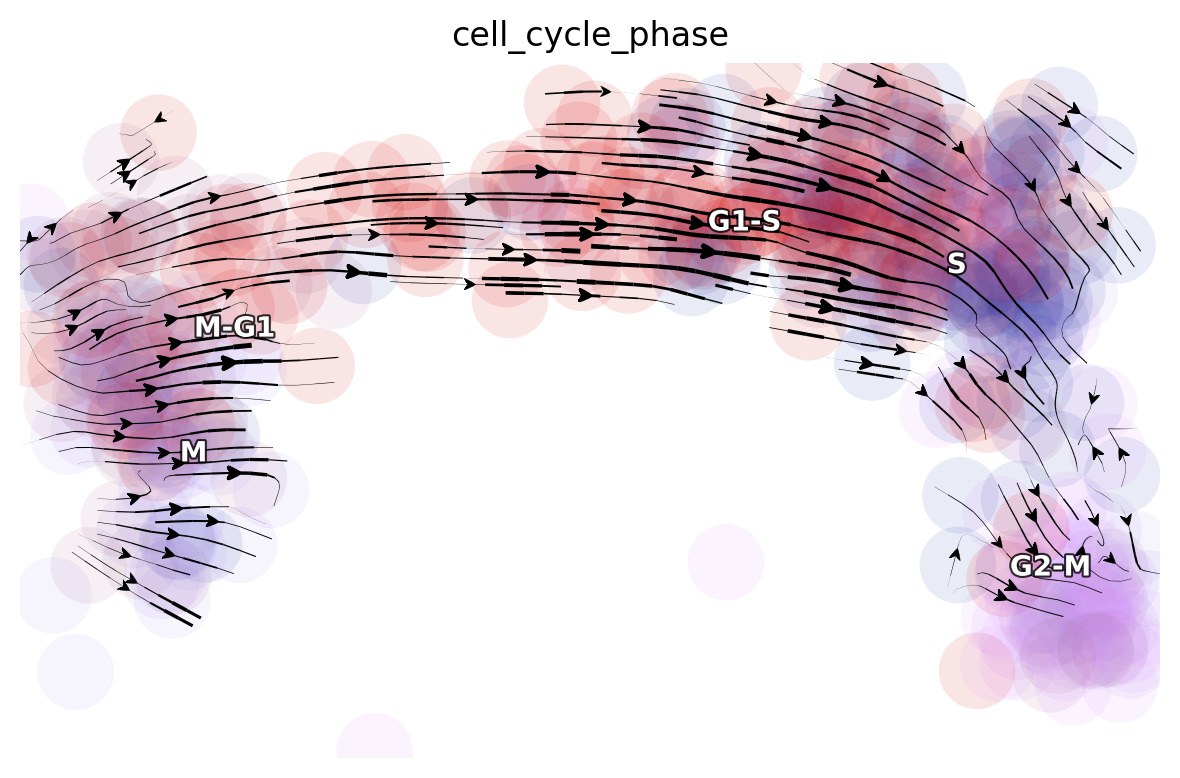

In [35]:
# 15 mins
dyn.pl.streamline_plot(rpe1_15min_CSPss, color=['cell_cycle_phase'], basis='RFP_GFP',save_show_or_return='show',
                       save_kwargs={'prefix': 'cell_cycle_rfp_gfp_15mins_cspss', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

<Figure size 600x400 with 0 Axes>

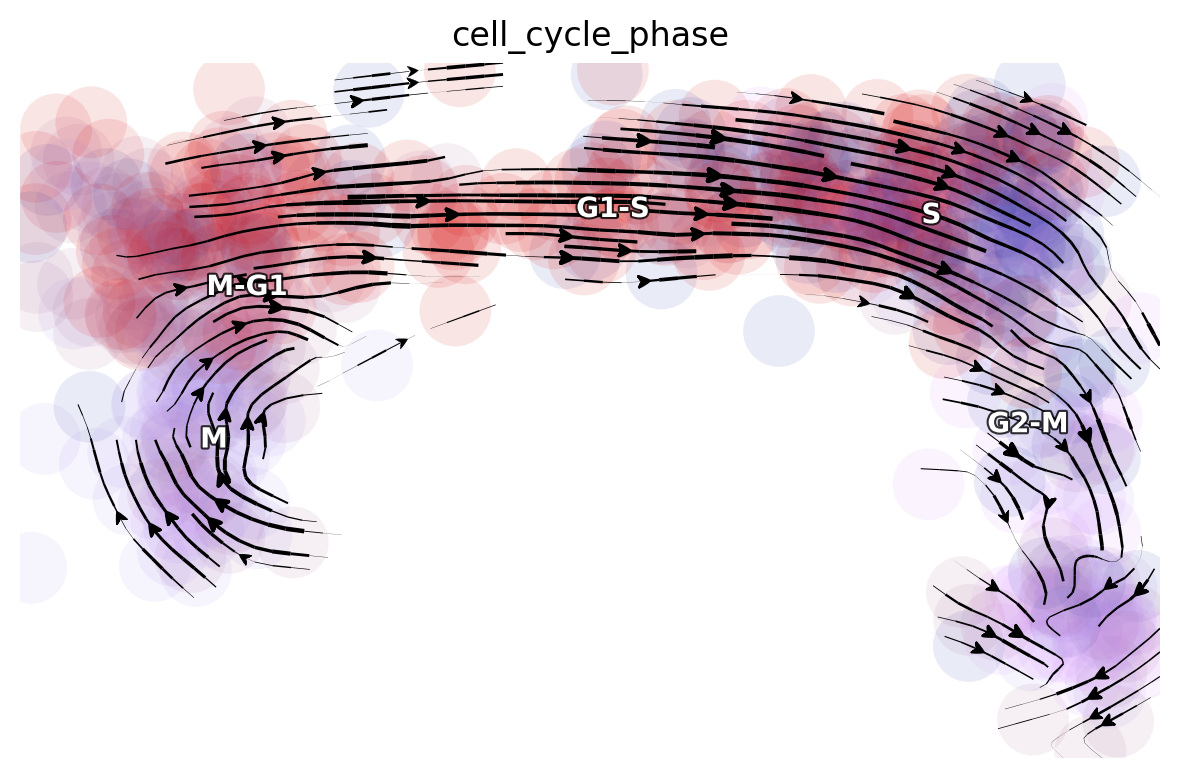

In [37]:
# 30 mins
dyn.pl.streamline_plot(rpe1_30min_CSPss, color=['cell_cycle_phase'], basis='RFP_GFP',save_show_or_return='show',
                       save_kwargs={'prefix': 'cell_cycle_rfp_gfp_30mins_cspss', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

Dynamo

<Figure size 600x400 with 0 Axes>

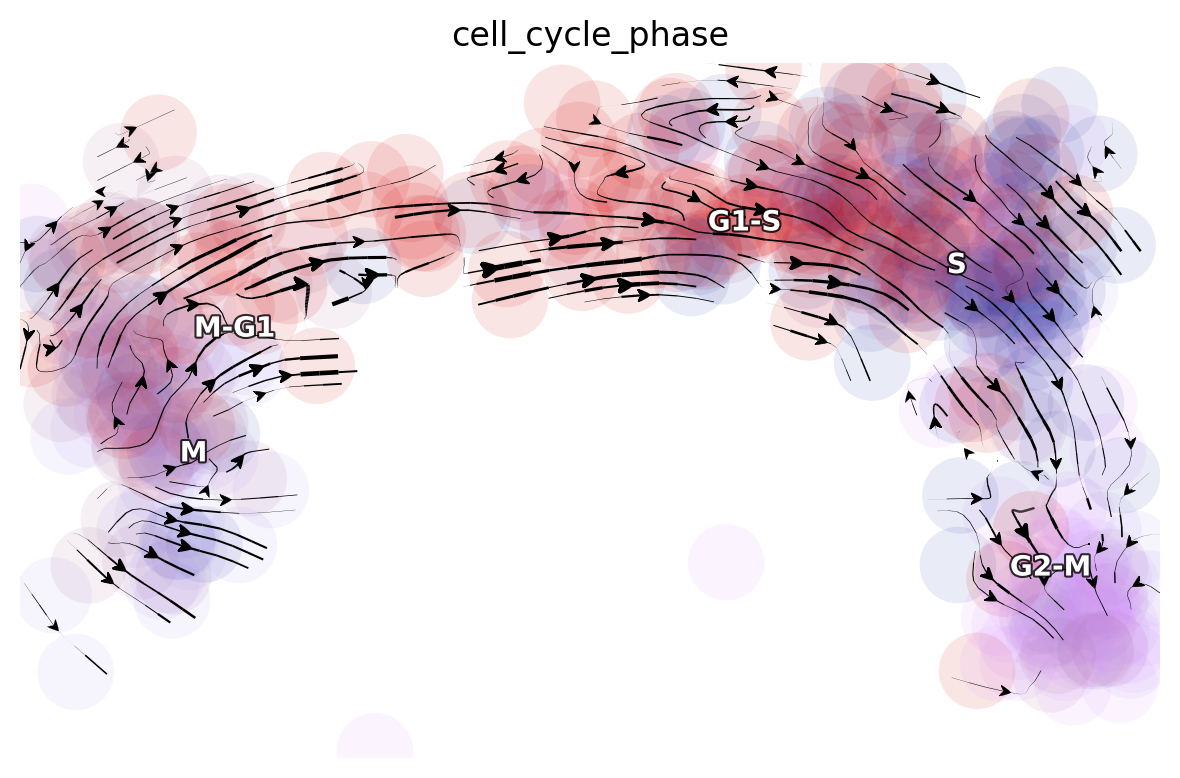

In [39]:
# 15 mins
dyn.pl.streamline_plot(rpe1_15min_Dynamo, color=['cell_cycle_phase'], basis='RFP_GFP',save_show_or_return='show',
                       save_kwargs={'prefix': 'cell_cycle_rfp_gfp_15mins_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

<Figure size 600x400 with 0 Axes>

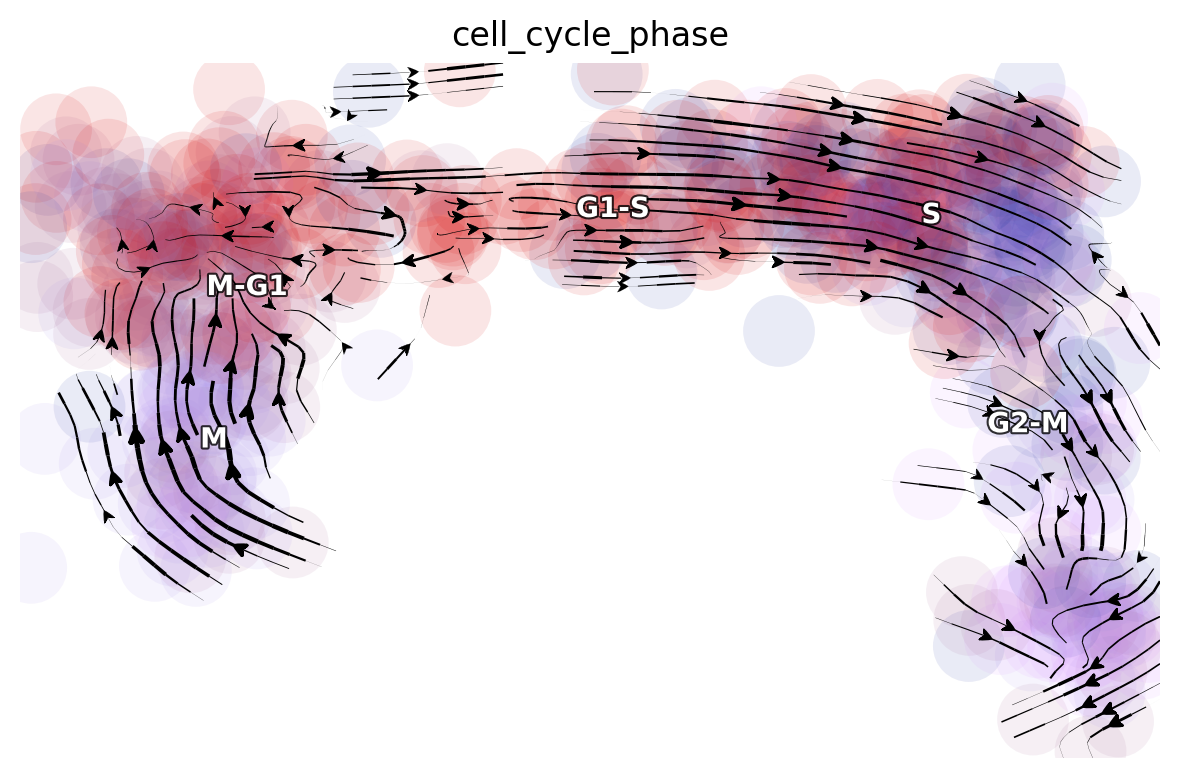

In [41]:
# 30 mins
dyn.pl.streamline_plot(rpe1_30min_Dynamo, color=['cell_cycle_phase'], basis='RFP_GFP',save_show_or_return='show',
                       save_kwargs={'prefix': 'cell_cycle_rfp_gfp_30mins_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

### Plot the inferred results of $\gamma_{t}$ of the two methods in the two sub-datasets

In [18]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

In [19]:
gamma_15min_CSPss = rpe1_15min_CSPss.var['gamma'].values
gamma_15min_Dynamo = rpe1_15min_Dynamo.var['gamma'].values
gamma_30min_CSPss = rpe1_30min_CSPss.var['gamma'].values
gamma_30min_Dynamo = rpe1_30min_Dynamo.var['gamma'].values

On the 15-minute labeling sub-dataset:

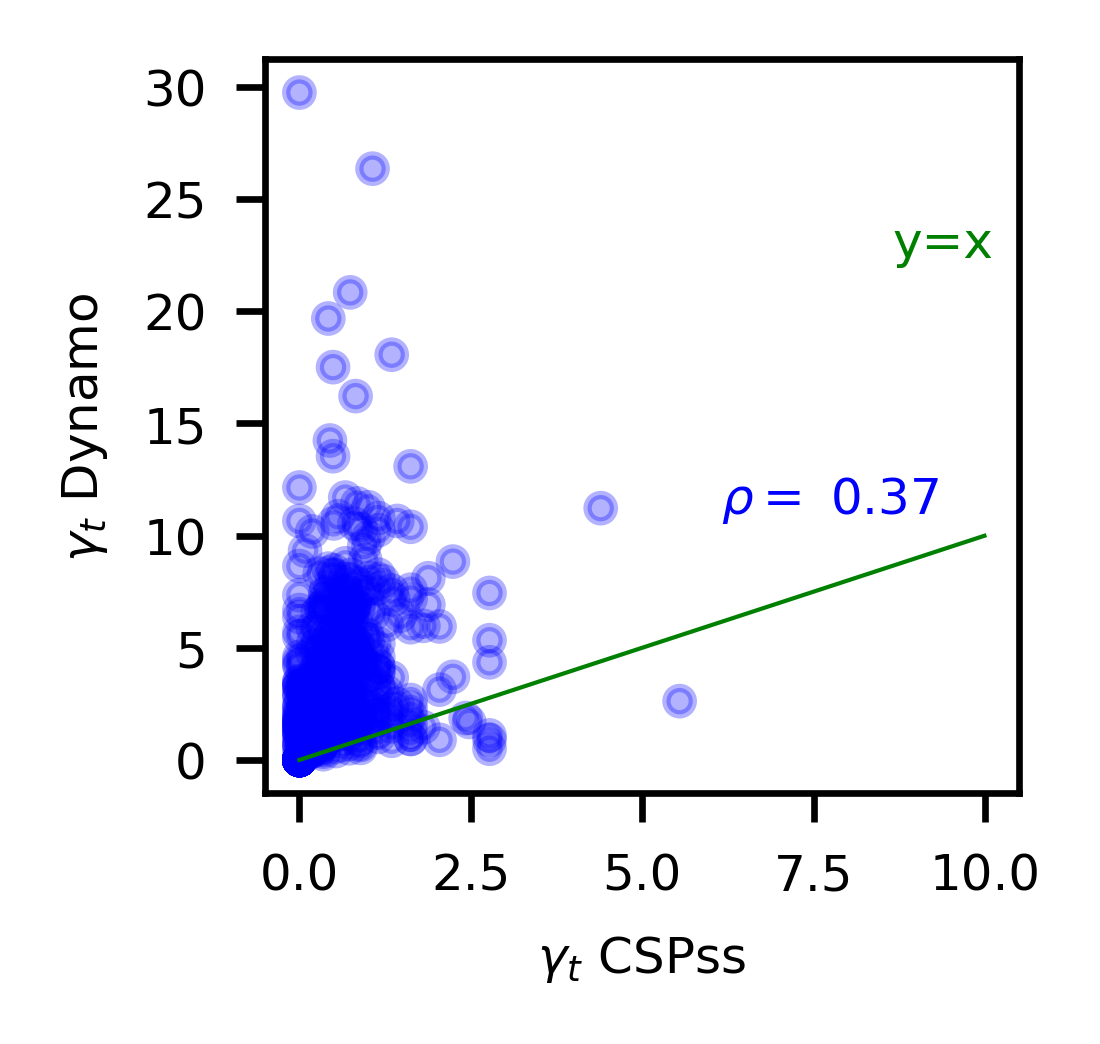

In [24]:
gamma_15min_CSPss = gamma_15min_CSPss.astype('float')
gamma_15min_Dynamo = gamma_15min_Dynamo.astype('float')


range_min = 0
range_max = 10
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_15min_CSPss), np.isfinite(gamma_15min_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_15min_CSPss[index_no_nan], gamma_15min_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_15min_CSPss, gamma_15min_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_15min_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
plt.savefig('./rev_figures/figure2/comp/cell_cycle_15min.pdf',dpi=dpi, bbox_inches="tight")
plt.show()

On the 30-minute labeling sub-dataset:

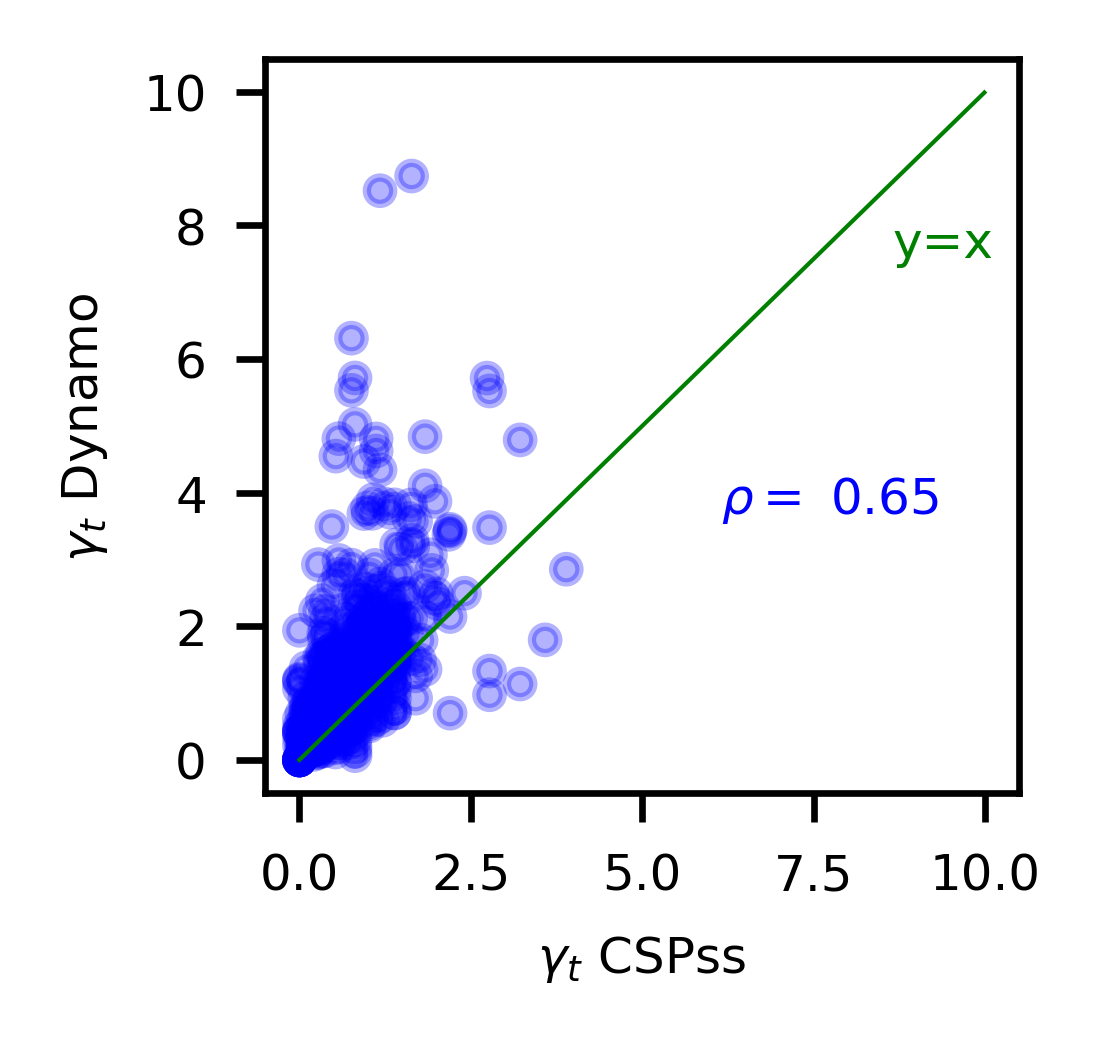

In [25]:
gamma_30min_CSPss = gamma_30min_CSPss.astype('float')
gamma_30min_Dynamo = gamma_30min_Dynamo.astype('float')

range_min = 0
range_max = 10
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_30min_CSPss), np.isfinite(gamma_30min_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_30min_CSPss[index_no_nan], gamma_30min_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_30min_CSPss, gamma_30min_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_30min_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
plt.savefig('./rev_figures/figure2/comp/cell_cycle_30min.pdf',dpi=dpi, bbox_inches="tight")
plt.show()

### Plot the results of $\gamma_t$ inference on different sub-datasets for Dynamo and CSPss respectively

CSPss:

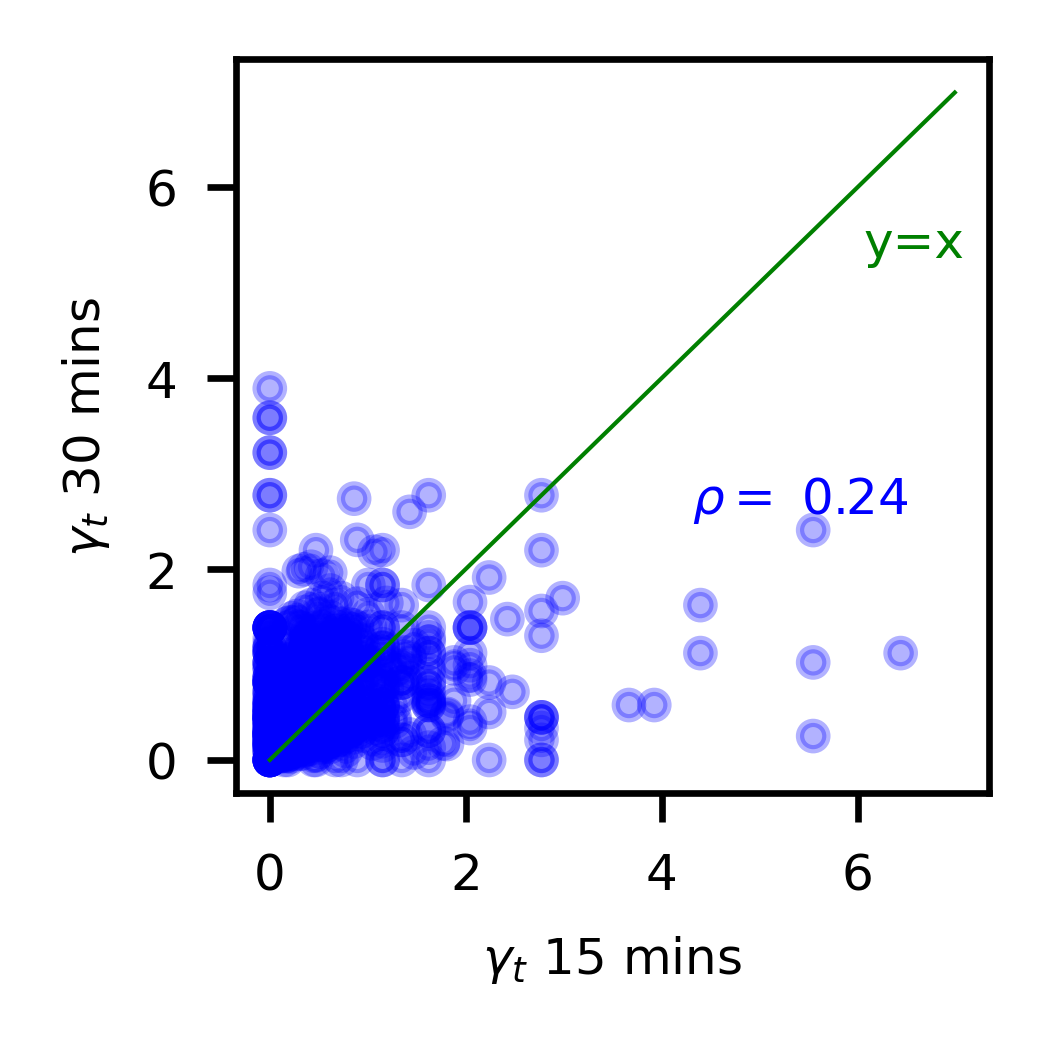

In [27]:
gamma_15min_CSPss = gamma_15min_CSPss.astype('float')
gamma_30min_CSPss = gamma_30min_CSPss.astype('float')

range_min = 0
range_max = 7
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_15min_CSPss), np.isfinite(gamma_30min_CSPss))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_15min_CSPss[index_no_nan], gamma_30min_CSPss[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_15min_CSPss, gamma_30min_CSPss, color='blue', s=scatter_size * np.ones(len(gamma_15min_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ 15 mins')
plt.ylabel('$\gamma_t$ 30 mins')
plt.grid(False)
plt.savefig('./rev_figures/figure2/comp/cell_cycle_cspss_diff_time.pdf',dpi=dpi, bbox_inches="tight")
plt.show()

Dynamo:

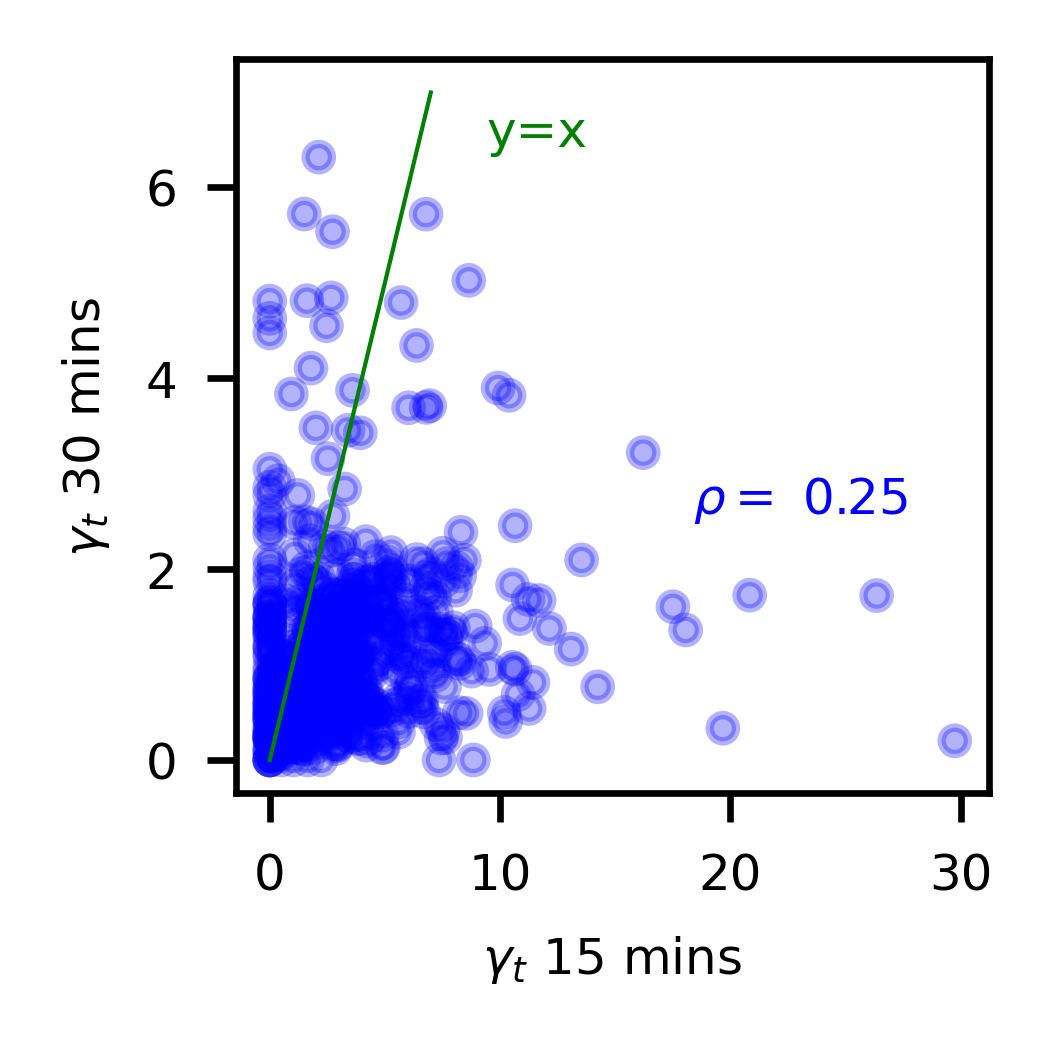

In [31]:
gamma_15min_Dynamo = gamma_15min_Dynamo.astype('float')
gamma_30min_Dynamo = gamma_30min_Dynamo.astype('float')

range_min = 0
range_max = 7
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_15min_Dynamo), np.isfinite(gamma_30min_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_15min_Dynamo[index_no_nan], gamma_30min_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_15min_Dynamo, gamma_30min_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_15min_Dynamo)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.4, 0.9, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ 15 mins')
plt.ylabel('$\gamma_t$ 30 mins')
plt.grid(False)
plt.savefig('./rev_figures/figure2/comp/cell_cycle_dynamo_diff_time.pdf',dpi=dpi, bbox_inches="tight")
plt.show()

The results show that our method is more consistent compared with Dynamo.